In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
import os
import sys
sys.path.append("..")
import util    # helper functions

In [2]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 12, 9, 7, 9, 856315)

In [3]:
# Get relevant secrets and variables

print("Connecting to Hopsworks...")
hopsworks_key = os.getenv("HOPSWORKS_API_KEY") 
hopsworks_project_name = os.getenv("HOPSWORKS_PROJECT")
project = hopsworks.login(project=hopsworks_project_name, api_key_value=hopsworks_key) 
fs = project.get_feature_store()

with open("../city_config/gothenburg_femman.json") as f:
    city_config = json.load(f)

country = city_config["city_name"]
city = city_config["country_name"]
street = city_config["street_name"]
LAT = city_config["city_lat"]
LON = city_config["city_lon"]
SENSOR = city_config["sensors"][0] 
FG_VERSIONS = city_config["fg_versions"]

feature_view = city_config["feature_view"]
feature_view_name = feature_view["name"]
feature_view_version = feature_view["version"]

model_registry = city_config["model_registry"]
model_name = model_registry["name"]
model_version = model_registry["version"]

Connecting to Hopsworks...
2025-11-12 09:15:33,165 INFO: Initializing external client
2025-11-12 09:15:33,172 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-12 09:15:34,644 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-12 09:15:35,947 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1271989


In [4]:
# Download the model from the model registry

mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name=model_name,
    version=model_version,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-12 09:16:07,952 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/335390 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/105704 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/19954 elapsed<00:00 remaining<?

In [5]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

,objective,'reg:squarederror'
,base_score,[26.609299]
,booster,'gbtree'
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [6]:
# Get weather forecast features
# weather_fg = fs.get_feature_group(
#     name='weather',
#     version=FG_VERSIONS["weather"],
# )

# batch_data = weather_fg.filter(weather_fg.date >= today).read()
# batch_data

forecast_fg = fs.get_feature_group(
    name='weather_forecast_features',
    version=FG_VERSIONS["weather_forecast_features"],
)
batch_data = forecast_fg.read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.66s) 


In [8]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['wind_speed_10m_max', 'wind_gusts_10m_max', 'wind_direction_10m_dominant', 'temperature_2m_max']])
batch_data

,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,temperature_2m_max,date,predicted_pm25
0,13.0,26.3,2,7.0,2025-11-14 00:00:00+00:00,23.982349
1,6.5,12.6,127,9.7,2025-11-08 00:00:00+00:00,32.840401
2,35.6,69.1,188,10.6,2025-11-12 00:00:00+00:00,28.468153
3,27.0,52.9,232,11.3,2025-11-13 00:00:00+00:00,26.309052
4,11.5,20.5,200,9.4,2025-11-10 00:00:00+00:00,34.859177
5,16.6,31.7,151,9.9,2025-11-11 00:00:00+00:00,31.735682
6,10.4,19.4,151,8.8,2025-11-09 00:00:00+00:00,34.321651
7,17.2,33.5,272,3.6,2025-11-15 00:00:00+00:00,24.548090
8,26.4,53.6,244,5.5,2025-11-16 00:00:00+00:00,23.841440
9,16.9,32.4,33,2.2,2025-11-17 00:00:00+00:00,20.024311


In [9]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   wind_speed_10m_max           11 non-null     float64                
 1   wind_gusts_10m_max           11 non-null     float64                
 2   wind_direction_10m_dominant  11 non-null     int64                  
 3   temperature_2m_max           11 non-null     float64                
 4   date                         11 non-null     datetime64[us, Etc/UTC]
 5   predicted_pm25               11 non-null     float32                
dtypes: datetime64[us, Etc/UTC](1), float32(1), float64(3), int64(1)
memory usage: 612.0 bytes


In [10]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country

# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,temperature_2m_max,date,predicted_pm25,street,city,country,days_before_forecast_day
1,6.5,12.6,127,9.7,2025-11-08 00:00:00+00:00,32.840401,Femman,Sweden,Göteborg,2
6,10.4,19.4,151,8.8,2025-11-09 00:00:00+00:00,34.321651,Femman,Sweden,Göteborg,7
4,11.5,20.5,200,9.4,2025-11-10 00:00:00+00:00,34.859177,Femman,Sweden,Göteborg,5
5,16.6,31.7,151,9.9,2025-11-11 00:00:00+00:00,31.735682,Femman,Sweden,Göteborg,6
2,35.6,69.1,188,10.6,2025-11-12 00:00:00+00:00,28.468153,Femman,Sweden,Göteborg,3
3,27.0,52.9,232,11.3,2025-11-13 00:00:00+00:00,26.309052,Femman,Sweden,Göteborg,4
0,13.0,26.3,2,7.0,2025-11-14 00:00:00+00:00,23.982349,Femman,Sweden,Göteborg,1
7,17.2,33.5,272,3.6,2025-11-15 00:00:00+00:00,24.548090,Femman,Sweden,Göteborg,8
8,26.4,53.6,244,5.5,2025-11-16 00:00:00+00:00,23.841440,Femman,Sweden,Göteborg,9
9,16.9,32.4,33,2.2,2025-11-17 00:00:00+00:00,20.024311,Femman,Sweden,Göteborg,10


In [11]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11 entries, 1 to 10
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   wind_speed_10m_max           11 non-null     float64                
 1   wind_gusts_10m_max           11 non-null     float64                
 2   wind_direction_10m_dominant  11 non-null     int64                  
 3   temperature_2m_max           11 non-null     float64                
 4   date                         11 non-null     datetime64[us, Etc/UTC]
 5   predicted_pm25               11 non-null     float32                
 6   street                       11 non-null     object                 
 7   city                         11 non-null     object                 
 8   country                      11 non-null     object                 
 9   days_before_forecast_day     11 non-null     int64                  
dtypes: dateti

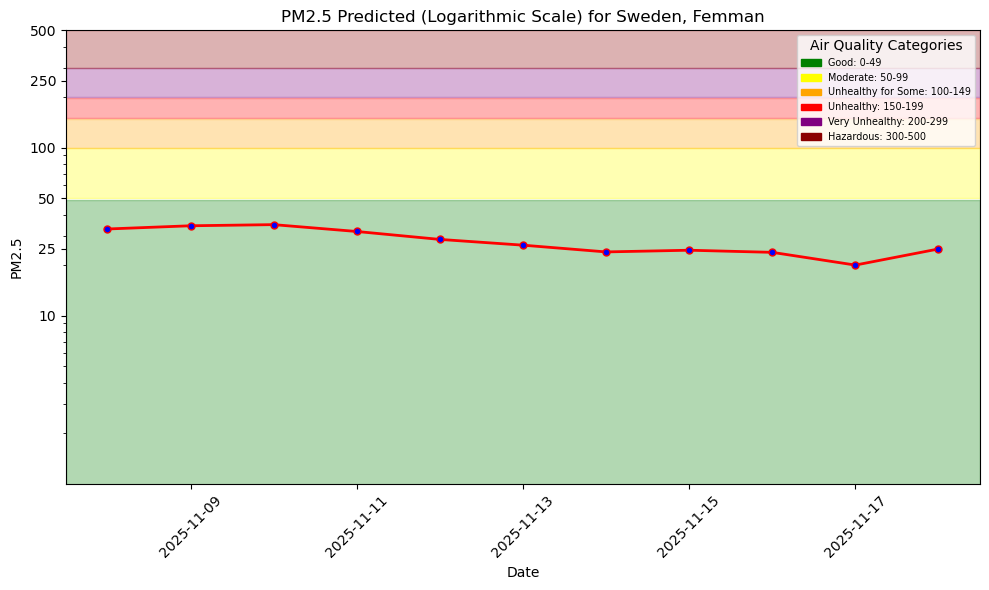

In [12]:
# Create a forecast graph:
# pred_file_path = "../docs/air-quality/assets/img/pm25_forecast.png"
pred_file_path = "../air_quality_model/images/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [ ]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=FG_VERSIONS["aq_predictions"],
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [17]:
monitor_fg.insert(batch_data, wait=True)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1271989/fs/1258587/fg/1668733


Uploading Dataframe: 100.00% |██████████| Rows 11/11 | Elapsed Time: 00:00 | Remaining Time: 00:00


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1271989/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-11-12 09:29:38,145 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-12 09:29:44,489 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-12 09:31:23,142 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-12 09:31:23,303 INFO: Waiting for log aggregation to finish.
2025-11-12 09:31:31,947 INFO: Execution finished successfully.


(Job('aq_predictions_1_offline_fg_materialization', 'SPARK'), None)

In [18]:
# We will create a hindcast chart for only the forecasts made 1 day beforehand (can view for more days)
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.21s) 


,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,temperature_2m_max,date,predicted_pm25,street,city,country,days_before_forecast_day
0,13.0,26.3,2,7.0,2025-11-14 00:00:00+00:00,23.982349,Femman,Sweden,Göteborg,1


In [19]:
air_quality_fg = fs.get_feature_group(name='air_quality', version=FG_VERSIONS["air_quality"])
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.32s) 


,date,pm2_5,country,city,street
0,2025-01-18 00:00:00+00:00,42.0,Sweden,Göteborg,Femman
1,2024-03-25 00:00:00+00:00,8.0,Sweden,Göteborg,Femman
2,2020-02-13 00:00:00+00:00,12.0,Sweden,Göteborg,Femman
3,2022-08-03 00:00:00+00:00,38.0,Sweden,Göteborg,Femman
4,2021-04-08 00:00:00+00:00,6.0,Sweden,Göteborg,Femman
...,...,...,...,...,...
2081,2025-11-16 19:00:00+00:00,NaN,Sweden,Göteborg,Femman
2082,2025-11-16 05:00:00+00:00,4.3,Sweden,Göteborg,Femman
2083,2025-11-16 11:00:00+00:00,3.6,Sweden,Göteborg,Femman
2084,2025-11-16 01:00:00+00:00,3.0,Sweden,Göteborg,Femman


In [ ]:
outcome_df = air_quality_df[['date', 'pm2_5']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

# 1-to-1 validation if we only have exactly one prediction per date, otherwise many-to-one (will need to change this later)
hindcast_df = pd.merge(preds_df, outcome_df, on="date", how="inner")     # Inner join to keep only dates that are in both dfs
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,pm2_5
0,2025-11-14 00:00:00+00:00,23.982349,3.4


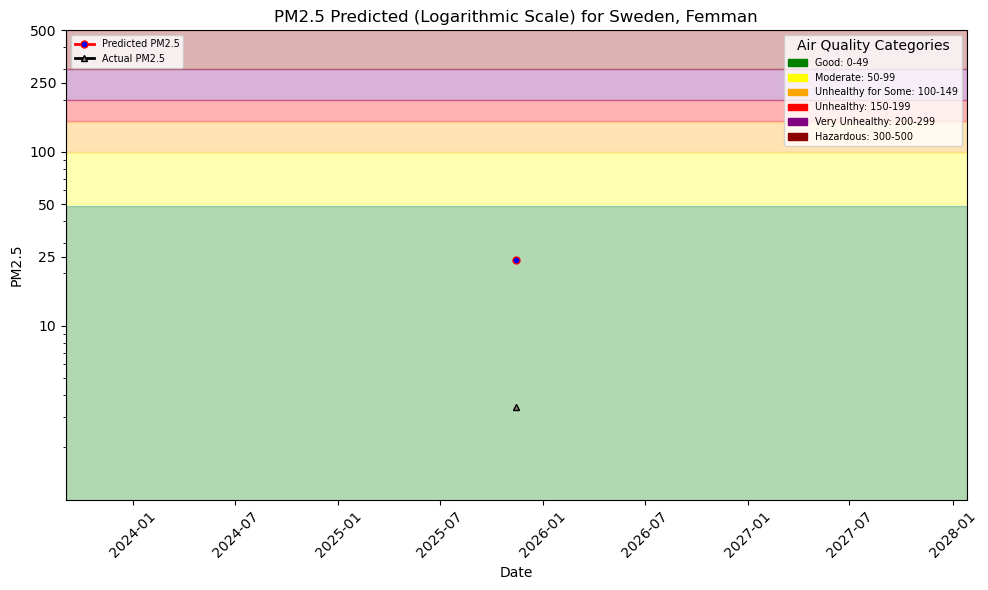

In [21]:
# Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)
# After a few days of predictions and observations, you will get data points in this graph.

hindcast_file_path = "../air_quality_model/images/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

In [22]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /Users/kajsalidin/Desktop/ID2223_air_quality_prediction/pipelines/../air_quality_model/images/pm25_f…

Uploading /Users/kajsalidin/Desktop/ID2223_air_quality_prediction/pipelines/../air_quality_model/images/pm25_h…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1271989/settings/fb/path/Resources/airquality
